In [20]:
# To visualize plots in the notebook
%matplotlib inline

# Imported libraries
import csv
import random
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

%config InlineBackend.figure_format = 'retina' 

In [23]:
# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 300

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,
    
    # Fonts
    'font.size': 10,
    
    # Axes
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'axes.linewidth': 0.5,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'grid.color': 'gray',
    
    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,
    
    # Lines
   'lines.linewidth': 1.0, # set the default linewidth for plot lines to 1.0 points
   'lines.markersize': 4, # set the default marker size for plot markers to 6 points
    
    'axes.labelsize': 10, # set the font size of the axis labels to 10 points
    'axes.titlesize': 12, # set the font size of the plot title to 12 points
    'xtick.labelsize': 8, # set the font size of the x-axis tick labels to 8 points
    'ytick.labelsize': 8, # set the font size of the y-axis tick labels to 8 points
})

In [2]:
!pip install pyemd

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 KB 5.8 MB/s eta 0:00:00:00:01


In [3]:
import argparse
import json
import shutil
import sys
import warnings
from pathlib import Path

import numpy as np
import scipy.sparse as sparse

In [4]:
class TMmodel(object):
    # This class represents a Topic Model according to the LDA generative model
    # Essentially the TM is characterized by
    # _alphas: The weight of each topic
    # _betas: The weight of each word in the vocabulary
    # _thetas: The weight of each topic in each document
    #
    # and needs to be backed up with a folder in which all the associated
    # files will be saved
    #
    # The TM can be trained with Blei's LDA, Mallet, or any other toolbox
    # that produces a model according to this representation

    # The following variables will store original values of matrices alphas, betas, thetas
    # They will be used to reset the model to original values

    _TMfolder = None

    _betas_orig = None
    _thetas_orig = None
    _alphas_orig = None

    _betas = None
    _thetas = None
    _alphas = None
    _edits = None  # Store all editions made to the model
    _ntopics = None
    _betas_ds = None
    _topic_entropy = None
    _topic_coherence = None
    _ndocs_active = None
    _tpc_descriptions = None
    _tpc_labels = None
    _vocab_w2id = None
    _vocab_id2w = None
    _vocab = None
    _size_vocab = None

    def __init__(self, TMfolder, logger=None):
        """Class initializer
        We just need to make sure that we have a folder where the
        model will be stored. If the folder does not exist, it will
        create a folder for the model
        Parameters
        ----------
        TMfolder: Path
            Contains the name of an existing folder or a new folder
            where the model will be created
        logger:
            External logger to use. If None, a logger will be created for the object
        """
        if logger:
            self._logger = logger
        else:
            import logging
            logging.basicConfig(level='INFO')
            self._logger = logging.getLogger('TMmodel')

        # Convert strings to Paths if necessary
        self._TMfolder = Path(TMfolder)

        # If folder already exists no further action is needed
        # in other case, the folder is created
        if not self._TMfolder.is_dir():
            try:
                self._TMfolder.mkdir(parents=True)
            except:
                self._logger.error(
                    '-- -- Topic model object (TMmodel) could not be created')

        self._logger.info(
            '-- -- -- Topic model object (TMmodel) successfully created')

    def create(self, betas=None, thetas=None, alphas=None, vocab=None, labels=None):
        """Creates the topic model from the relevant matrices that characterize it. In addition to the initialization of the corresponding object's variables, all the associated variables and visualizations which are computationally costly are calculated so they are available for the other methods.
        Parameters
        ----------
        betas:
            Matrix of size n_topics x n_words (vocab of each topic)
        thetas:
            Matrix of size  n_docs x n_topics (document composition)
        alphas: 
            Vector of length n_topics containing the importance of each topic
        vocab: list
            List of words sorted according to betas matrix
        labels: list
            List of  labels for automatic topic labeling
        """

        # If folder already exists no further action is needed
        # in other case, the folder is created
        if not self._TMfolder.is_dir():
            self._logger.error(
                '-- -- Topic model object (TMmodel) folder not ready')
            return

        self._alphas_orig = alphas
        self._betas_orig = betas
        self._thetas_orig = thetas
        self._alphas = alphas
        self._betas = betas
        self._thetas = thetas
        self._vocab = vocab
        self._size_vocab = len(vocab)
        self._ntopics = thetas.shape[1]
        self._edits = []

        # Save original variables
        np.save(self._TMfolder.joinpath('alphas_orig.npy'), alphas)
        np.save(self._TMfolder.joinpath('betas_orig.npy'), betas)
        sparse.save_npz(self._TMfolder.joinpath('thetas_orig.npz'), thetas)
        with self._TMfolder.joinpath('vocab.txt').open('w', encoding='utf8') as fout:
            fout.write('\n'.join(vocab))

        # Initial sort of topics according to size. Calculate other variables
        self._sort_topics()
        self._calculate_beta_ds()
        self._calculate_topic_entropy()
        self._ndocs_active = np.array((self._thetas != 0).sum(0).tolist()[0])
        self._tpc_descriptions = [el[1]
                                  for el in self.get_tpc_word_descriptions()]
        self.calculate_topic_coherence(metric="c_npmi")
        self._tpc_labels = [el[1] for el in self.get_tpc_labels(labels)]

        # We are ready to save all variables in the model
        self._save_all()

        self._logger.info(
            '-- -- Topic model variables were computed and saved to file')
        return

    def _save_all(self):
        """Saves all variables in Topic Model
        * alphas, betas, thetas
        * edits
        * betas_ds, topic_entropy, ndocs_active
        * tpc_descriptions, tpc_labels
        This function should only be called after making sure all these
        variables exist and are not None
        """
        np.save(self._TMfolder.joinpath('alphas.npy'), self._alphas)
        np.save(self._TMfolder.joinpath('betas.npy'), self._betas)
        sparse.save_npz(self._TMfolder.joinpath('thetas.npz'), self._thetas)

        with self._TMfolder.joinpath('edits.txt').open('w', encoding='utf8') as fout:
            fout.write('\n'.join(self._edits))
        np.save(self._TMfolder.joinpath('betas_ds.npy'), self._betas_ds)
        np.save(self._TMfolder.joinpath(
            'topic_entropy.npy'), self._topic_entropy)
        np.save(self._TMfolder.joinpath(
            'topic_coherence.npy'), self._topic_coherence)
        np.save(self._TMfolder.joinpath(
            'ndocs_active.npy'), self._ndocs_active)
        with self._TMfolder.joinpath('tpc_descriptions.txt').open('w', encoding='utf8') as fout:
            fout.write('\n'.join(self._tpc_descriptions))
        with self._TMfolder.joinpath('tpc_labels.txt').open('w', encoding='utf8') as fout:
            fout.write('\n'.join(self._tpc_labels))

        # Generate also pyLDAvisualization
        # pyLDAvis currently raises some Deprecation warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=DeprecationWarning)
            import pyLDAvis

        # We will compute the visualization using ndocs random documents
        # In case the model has gone through topic deletion, we may have rows
        # in the thetas matrix that sum up to zero (active topics have been
        # removed for these problematic documents). We need to take this into
        # account
        ndocs = 10000
        validDocs = np.sum(self._thetas.toarray(), axis=1) > 0
        nValidDocs = np.sum(validDocs)
        if ndocs > nValidDocs:
            ndocs = nValidDocs
        perm = np.sort(np.random.permutation(nValidDocs)[:ndocs])
        # We consider all documents are equally important
        doc_len = ndocs * [1]
        vocabfreq = np.round(ndocs*(self._alphas.dot(self._betas))).astype(int)
        vis_data = pyLDAvis.prepare(self._betas, self._thetas[validDocs, ][perm, ].toarray(),
                                    doc_len, self._vocab, vocabfreq, lambda_step=0.05,
                                    sort_topics=False, n_jobs=-1)

        with self._TMfolder.joinpath("pyLDAvis.html").open("w") as f:
            pyLDAvis.save_html(vis_data, f)
        # TODO: Check substituting by "pyLDAvis.prepared_data_to_html"
        self._modify_pyldavis_html(self._TMfolder.as_posix())

        return

    def _modify_pyldavis_html(self, model_dir):
        """
        Modifies the PyLDAvis HTML file returned by the Gensim library to include the direct paths of the 'd3.js' and 'ldavis.v3.0.0.js', which are copied into the model/submodel directory.
        Parameters
        ----------
        model_dir: str
            String representation of the path wwhere the model/submodel is located
        """

        # Copy necessary files in model / submodel folder for PyLDAvis visualization
        d3 = Path("src/gui/resources/d3.js")
        v3 = Path("src/gui/resources/ldavis.v3.0.0.js")
        shutil.copyfile(d3, Path(model_dir, "d3.js"))
        shutil.copyfile(v3, Path(model_dir, "ldavis.v3.0.0.js"))

        # Update d3 and v3 paths in pyldavis.html
        fin = open(Path(model_dir, "pyLDAvis.html").as_posix(),
                   "rt")  # read input file
        data = fin.read()  # read file contents to string
        # Replace all occurrences of the required string
        data = data.replace(
            "https://d3js.org/d3.v5.js", "d3.js")
        data = data.replace(
            "https://d3js.org/d3.v5", "d3.js")
        data = data.replace(
            "https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v3.0.0.js", "ldavis.v3.0.0.js")
        fin.close()  # close the input file
        fin = open(Path(model_dir, "pyLDAvis.html").as_posix(),
                   "wt")  # open the input file in write mode
        fin.write(data)  # overrite the input file with the resulting data
        fin.close()  # close the file

        return

    def _sort_topics(self):
        """Sort topics according to topic size"""

        # Load information if necessary
        self._load_alphas()
        self._load_betas()
        self._load_thetas()
        self._load_edits()

        # Indexes for topics reordering
        idx = np.argsort(self._alphas)[::-1]
        self._edits.append('s ' + ' '.join([str(el) for el in idx]))

        # Sort data matrices
        self._alphas = self._alphas[idx]
        self._betas = self._betas[idx, :]
        self._thetas = self._thetas[:, idx]

        return

    def _load_alphas(self):
        if self._alphas is None:
            self._alphas = np.load(self._TMfolder.joinpath('alphas.npy'))
            self._ntopics = self._alphas.shape[0]

    def _load_betas(self):
        if self._betas is None:
            self._betas = np.load(self._TMfolder.joinpath('betas.npy'))
            self._ntopics = self._betas.shape[0]
            self._size_vocab = self._betas.shape[1]

    def _load_thetas(self):
        if self._thetas is None:
            self._thetas = sparse.load_npz(
                self._TMfolder.joinpath('thetas.npz'))
            self._ntopics = self._thetas.shape[1]
            #self._ndocs_active = np.array((self._thetas != 0).sum(0).tolist()[0])

    def _load_ndocs_active(self):
        if self._ndocs_active is None:
            self._ndocs_active = np.load(
                self._TMfolder.joinpath('ndocs_active.npy'))
            self._ntopics = self._ndocs_active.shape[0]

    def _load_edits(self):
        if self._edits is None:
            with self._TMfolder.joinpath('edits.txt').open('r', encoding='utf8') as fin:
                self._edits = fin.readlines()

    def _calculate_beta_ds(self):
        """Calculates beta with down-scoring
        Emphasizes words appearing less frequently in topics
        """
        # Load information if necessary
        self._load_betas()

        self._betas_ds = np.copy(self._betas)
        if np.min(self._betas_ds) < 1e-12:
            self._betas_ds += 1e-12
        deno = np.reshape((sum(np.log(self._betas_ds)) /
                          self._ntopics), (self._size_vocab, 1))
        deno = np.ones((self._ntopics, 1)).dot(deno.T)
        self._betas_ds = self._betas_ds * (np.log(self._betas_ds) - deno)

    def _load_betas_ds(self):
        if self._betas_ds is None:
            self._betas_ds = np.load(self._TMfolder.joinpath('betas_ds.npy'))
            self._ntopics = self._betas_ds.shape[0]
            self._size_vocab = self._betas_ds.shape[1]

    def _load_vocab(self):
        if self._vocab is None:
            with self._TMfolder.joinpath('vocab.txt').open('r', encoding='utf8') as fin:
                self._vocab = [el.strip() for el in fin.readlines()]

    def _load_vocab_dicts(self):
        """Creates two vocabulary dictionaries, one that utilizes the words as key, and a second one with the words' id as key. 
        """
        if self._vocab_w2id is None and self._vocab_w2id is None:
            self._vocab_w2id = {}
            self._vocab_id2w = {}
            with self._TMfolder.joinpath('vocab.txt').open('r', encoding='utf8') as fin:
                for i, line in enumerate(fin):
                    wd = line.strip()
                    self._vocab_w2id[wd] = i
                    self._vocab_id2w[str(i)] = wd

    def _calculate_topic_entropy(self):
        """Calculates the entropy of all topics in model
        """
        # Load information if necessary
        self._load_betas()

        if np.min(self._betas) < 1e-12:
            self._betas += 1e-12
        self._topic_entropy = - \
            np.sum(self._betas * np.log(self._betas), axis=1)
        self._topic_entropy = self._topic_entropy / np.log(self._size_vocab)

    def _load_topic_entropy(self):
        if self._topic_entropy is None:
            self._topic_entropy = np.load(
                self._TMfolder.joinpath('topic_entropy.npy'))

    def calculate_topic_coherence(self, metric="c_npmi", n_words=15):

        # Load topic information
        if self._tpc_descriptions is None:
            self._tpc_descriptions = [el[1]
                                      for el in self.get_tpc_word_descriptions()]
        # Convert topic information into list of lists
        tpc_descriptions_ = \
            [tpc.split(', ') for tpc in self._tpc_descriptions]

        # Get texts to calculate coherence
        if self._TMfolder.parent.joinpath('modelFiles/corpus.txt').is_file():
            corpusFile = self._TMfolder.parent.joinpath(
                'modelFiles/corpus.txt')
        else:
            corpusFile = self._TMfolder.parent.joinpath('corpus.txt')
        with corpusFile.open("r", encoding="utf-8") as f:
            corpus = [line.rsplit(" 0 ")[1].strip().split()
                      for line in f.readlines()]

        # Import necessary modules for coherence calculation with Gensim
        # TODO: This needs to be substituted by a non-Gensim based calculation of the coherence
        from gensim.corpora import Dictionary
        from gensim.models.coherencemodel import CoherenceModel

        # Get Gensim dictionary
        dictionary = None
        if self._TMfolder.parent.joinpath('dictionary.gensim').is_file():
            try:
                dictionary = Dictionary.load_from_text(
                    self._TMfolder.parent.joinpath('dictionary.gensim').as_posix())
            except:
                self._logger.warning(
                    "Gensim dictionary could not be load from vocabulary file.")
        else:
            if dictionary is None:
                dictionary = Dictionary(corpus)

        if n_words > len(tpc_descriptions_[0]):
            self.logger.error(
                '-- -- -- Coherence calculation failed: The number of words per topic must be equal to n_words.')
        else:
            if metric in ["c_npmi", "u_mass", "c_v", "c_uci"]:
                cm = CoherenceModel(topics=tpc_descriptions_, texts=corpus,
                                    dictionary=dictionary, coherence=metric, topn=n_words)
                self._topic_coherence = cm.get_coherence_per_topic()
            else:
                self.logger.error(
                    '-- -- -- Coherence metric provided is not available.')

    def _load_topic_coherence(self):
        if self._topic_coherence is None:
            self._topic_coherence = np.load(
                self._TMfolder.joinpath('topic_coherence.npy'))

    def _largest_indices(self, ary, n):
        """Returns the n largest indices from a numpy array."""
        flat = ary.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        idx0, idx1 = np.unravel_index(indices, ary.shape)
        idx0 = idx0.tolist()
        idx1 = idx1.tolist()
        selected_idx = []
        for id0, id1 in zip(idx0, idx1):
            if id0 < id1:
                selected_idx.append((id0, id1, ary[id0, id1]))
        return selected_idx

    def get_model_info_for_hierarchical(self):
        """Returns the objects necessary for the creation of a level-2 topic model.
        """
        self._load_betas()
        self._load_thetas()
        self._load_vocab_dicts()

        return self._betas, self._thetas, self._vocab_w2id, self._vocab_id2w

    def get_tpc_word_descriptions(self, n_words=15, tfidf=True, tpc=None):
        """returns the chemical description of topics
        Parameters
        ----------
        n_words:
            Number of terms for each topic that will be included
        tfidf:
            If true, downscale the importance of words that appear
            in several topics, according to beta_ds (Blei and Lafferty, 2009)
        tpc:
            Topics for which the descriptions will be computed, e.g.: tpc = [0,3,4]
            If None, it will compute the descriptions for all topics  
        Returns
        -------
        tpc_descs: list of tuples
            Each element is a a term (topic_id, "word0, word1, ...")                      
        """

        # Load betas (including n_topics) and vocabulary
        if tfidf:
            self._load_betas_ds()
        else:
            self._load_betas()
        self._load_vocab()

        if not tpc:
            tpc = range(self._ntopics)

        tpc_descs = []
        for i in tpc:
            if tfidf:
                words = [self._vocab[idx2]
                         for idx2 in np.argsort(self._betas_ds[i])[::-1][0:n_words]]
            else:
                words = [self._vocab[idx2]
                         for idx2 in np.argsort(self._betas[i])[::-1][0:n_words]]
            tpc_descs.append((i, ', '.join(words)))
        return tpc_descs

    def load_tpc_descriptions(self):
        if self._tpc_descriptions is None:
            with self._TMfolder.joinpath('tpc_descriptions.txt').open('r', encoding='utf8') as fin:
                self._tpc_descriptions = [el.strip() for el in fin.readlines()]

    def get_tpc_labels(self, labels=None, use_cuda=True):
        """returns the labels of the topics in the model
        Parameters
        ----------
        labels: list
            List of labels for automatic topic labeling
        use_cuda: bool
            If True, use cuda.
        Returns
        -------
        tpc_labels: list of tuples
            Each element is a a term (topic_id, "label for topic topic_id")                    
        """
        if not labels:
            return [(i, "NA") for i, p in enumerate(self._tpc_descriptions)]

        if use_cuda:
            import torch
            if torch.cuda.is_available():
                device = 0
                self._logger.info("-- -- CUDA available: GPU will be used")
            else:
                device = -1
                self._logger.warning(
                    "-- -- 'use_cuda' set to True when cuda is unavailable."
                    "Make sure CUDA is available or set 'use_cuda=False'"
                )
                self._logger.info(
                    "-- -- CUDA unavailable: GPU will not be used")
        else:
            device = -1
            self._logger.info("-- -- CUDA unavailable: GPU will not be used")

        from transformers import pipeline
        classifier = pipeline("zero-shot-classification",
                              model="facebook/bart-large-mnli",
                              device=device)
        predictions = classifier(self._tpc_descriptions, labels)
        predictions = [(i, p["labels"][0]) for i, p in enumerate(predictions)]
        return predictions

    def load_tpc_labels(self):
        if self._tpc_labels is None:
            with self._TMfolder.joinpath('tpc_labels.txt').open('r', encoding='utf8') as fin:
                self._tpc_labels = [el.strip() for el in fin.readlines()]

    def showTopics(self):
        self._load_alphas()
        self._load_ndocs_active()
        self.load_tpc_descriptions()
        self.load_tpc_labels()
        TpcsInfo = [{"Size": str(round(el[0], 4)), "Label": el[1].strip(), "Word Description": el[2].strip(), "Ndocs Active": str(el[3])} for el in zip(
            self._alphas, self._tpc_labels, self._tpc_descriptions, self._ndocs_active)]

        return TpcsInfo

    def showTopicsAdvanced(self):
        self._load_alphas()
        self._load_ndocs_active()
        self.load_tpc_descriptions()
        self.load_tpc_labels()
        self._load_topic_entropy()
        self._load_topic_coherence()
        TpcsInfo = [{"Size": str(round(el[0], 4)), "Label": el[1].strip(), "Word Description": el[2].strip(), "Ndocs Active": str(el[3]), "Topics entropy": str(round(
            el[4], 4)), "Topics coherence": str(round(el[5], 4))} for el in zip(self._alphas, self._tpc_labels, self._tpc_descriptions, self._ndocs_active, self._topic_entropy, self._topic_coherence)]

        return TpcsInfo

    def setTpcLabels(self, TpcLabels):
        self._tpc_labels = [el.strip() for el in TpcLabels]
        self._load_alphas()
        # Check that the number of labels is consistent with model
        if len(TpcLabels) == self._ntopics:
            with self._TMfolder.joinpath('tpc_labels.txt').open('w', encoding='utf8') as fout:
                fout.write('\n'.join(self._tpc_labels))
            return 1
        else:
            return 0

    def deleteTopics(self, tpcs):
        """This is a costly operation, almost everything
        needs to get modified"""
        self._load_alphas()
        self._load_betas()
        self._load_thetas()
        self._load_betas_ds()
        self._load_topic_entropy()
        self._load_topic_coherence()
        self.load_tpc_descriptions()
        self.load_tpc_labels()
        self._load_ndocs_active()
        self._load_edits()
        self._load_vocab()

        try:
            # Get a list of the topics that should be kept
            tpc_keep = [k for k in range(self._ntopics) if k not in tpcs]
            tpc_keep = [k for k in tpc_keep if k < self._ntopics]

            # Calculate new variables
            self._thetas = self._thetas[:, tpc_keep]
            from sklearn.preprocessing import normalize
            self._thetas = normalize(self._thetas, axis=1, norm='l1')
            self._alphas = np.asarray(np.mean(self._thetas, axis=0)).ravel()
            self._ntopics = self._thetas.shape[1]
            self._betas = self._betas[tpc_keep, :]
            self._betas_ds = self._betas_ds[tpc_keep, :]
            self._ndocs_active = self._ndocs_active[tpc_keep]
            self._topic_entropy = self._topic_entropy[tpc_keep]
            self._topic_coherence = self._topic_coherence[tpc_keep]
            self._tpc_labels = [self._tpc_labels[i] for i in tpc_keep]
            self._tpc_descriptions = [
                self._tpc_descriptions[i] for i in tpc_keep]
            self._edits.append('d ' + ' '.join([str(k) for k in tpcs]))

            # We are ready to save all variables in the model
            self._save_all()

            self._logger.info(
                '-- -- Topics deletion successful. All variables saved to file')
            return 1
        except:
            self._logger.info(
                '-- -- Topics deletion generated an error. Operation failed')
            return 0

    def getSimilarTopics(self, npairs, thr=1e-3):
        """Obtains pairs of similar topics
        npairs: number of pairs of words
        thr: threshold for vocabulary thresholding
        """

        self._load_thetas()
        self._load_betas()

        # Part 1 - Coocurring topics
        # Highly correlated topics co-occure together
        # Topic mean
        med = np.asarray(np.mean(self._thetas, axis=0)).ravel()
        # Topic square mean
        thetas2 = self._thetas.multiply(self._thetas)
        med2 = np.asarray(np.mean(thetas2, axis=0)).ravel()
        # Topic stds
        stds = np.sqrt(med2 - med ** 2)
        # Topic correlation
        num = self._thetas.T.dot(
            self._thetas).toarray() / self._thetas.shape[0]
        num = num - med[..., np.newaxis].dot(med[np.newaxis, ...])
        deno = stds[..., np.newaxis].dot(stds[np.newaxis, ...])
        corrcoef = num / deno
        selected_coocur = self._largest_indices(
            corrcoef, self._ntopics + 2 * npairs)
        selected_coocur = [(el[0], el[1], el[2].astype(float))
                           for el in selected_coocur]

        # Part 2 - Topics with similar word composition
        # Computes inter-topic distance based on word distributions
        # using scipy implementation of Jensen Shannon distance
        from scipy.spatial.distance import jensenshannon

        # For a more efficient computation with very large vocabularies
        # we implement a threshold for restricting the distance calculation
        # to columns where any element is greater than threshold thr
        betas_aux = self._betas[:, np.where(self._betas.max(axis=0) > thr)[0]]
        js_mat = np.zeros((self._ntopics, self._ntopics))
        for k in range(self._ntopics):
            for kk in range(self._ntopics):
                js_mat[k, kk] = jensenshannon(
                    betas_aux[k, :], betas_aux[kk, :])
        JSsim = 1 - js_mat
        selected_worddesc = self._largest_indices(
            JSsim, self._ntopics + 2 * npairs)
        selected_worddesc = [(el[0], el[1], el[2].astype(float))
                             for el in selected_worddesc]

        similarTopics = {
            'Coocurring': selected_coocur,
            'Worddesc': selected_worddesc
        }

        return similarTopics

    def fuseTopics(self, tpcs):
        """This is a costly operation, almost everything
        needs to get modified"""
        self._load_alphas()
        self._load_betas()
        self._load_thetas()
        # self._load_topic_coherence()
        self.load_tpc_descriptions()
        self.load_tpc_labels()
        self._load_edits()
        self._load_vocab()

        try:
            # List of topics that will be merged
            tpcs = sorted(tpcs)

            # Calculate new variables
            # For beta we keep a weighted average of topic vectors
            weights = self._alphas[tpcs]
            bet = weights[np.newaxis, ...].dot(
                self._betas[tpcs, :]) / (sum(weights))
            # keep new topic vector in upper position and delete the others
            self._betas[tpcs[0], :] = bet
            self._betas = np.delete(self._betas, tpcs[1:], 0)
            # For theta we need to keep the sum. Since adding implies changing
            # structure, we need to convert to full matrix first
            # No need to renormalize
            thetas_full = self._thetas.toarray()
            thet = np.sum(thetas_full[:, tpcs], axis=1)
            thetas_full[:, tpcs[0]] = thet
            thetas_full = np.delete(thetas_full, tpcs[1:], 1)
            self._thetas = sparse.csr_matrix(thetas_full, copy=True)
            # Compute new alphas and number of topics
            self._alphas = np.asarray(np.mean(self._thetas, axis=0)).ravel()
            self._ntopics = self._thetas.shape[1]
            # Compute all other variables
            self._calculate_beta_ds()
            self._calculate_topic_entropy()
            self._ndocs_active = np.array(
                (self._thetas != 0).sum(0).tolist()[0])

            # Keep label and description of most significant topic
            for tpc in tpcs[1:][::-1]:
                del self._tpc_descriptions[tpc]
            # Recalculate chemical description of most significant topic
            self._tpc_descriptions[tpcs[0]] = self.get_tpc_word_descriptions(tpc=[tpcs[0]])[
                0][1]
            for tpc in tpcs[1:][::-1]:
                del self._tpc_labels[tpc]

            self.calculate_topic_coherence()
            self._edits.append('f ' + ' '.join([str(el) for el in tpcs]))
            # We are ready to save all variables in the model
            self._save_all()

            self._logger.info(
                '-- -- Topics merging successful. All variables saved to file')
            return 1
        except:
            self._logger.info(
                '-- -- Topics merging generated an error. Operation failed')
            return 0

    def sortTopics(self):
        """This is a costly operation, almost everything
        needs to get modified"""
        self._load_alphas()
        self._load_betas()
        self._load_thetas()
        self._load_betas_ds()
        self._load_topic_entropy()
        self._load_topic_coherence()
        self.load_tpc_descriptions()
        self.load_tpc_labels()
        self._load_ndocs_active()
        self._load_edits()
        self._load_vocab()

        try:
            # Calculate order for the topics
            idx = np.argsort(self._alphas)[::-1]
            self._edits.append('s ' + ' '.join([str(el) for el in idx]))

            # Calculate new variables
            self._thetas = self._thetas[:, idx]
            self._alphas = self._alphas[idx]
            self._betas = self._betas[idx, :]
            self._betas_ds = self._betas_ds[idx, :]
            self._ndocs_active = self._ndocs_active[idx]
            self._topic_entropy = self._topic_entropy[idx]
            self._topic_coherence = self._topic_coherence[idx]
            self._tpc_labels = [self._tpc_labels[i] for i in idx]
            self._tpc_descriptions = [self._tpc_descriptions[i] for i in idx]
            self._edits.append('s ' + ' '.join([str(el) for el in idx]))

            # We are ready to save all variables in the model
            self._save_all()

            self._logger.info(
                '-- -- Topics reordering successful. All variables saved to file')
            return 1
        except:
            self._logger.info(
                '-- -- Topics reordering generated an error. Operation failed')
            return 0

    def resetTM(self):
        self._alphas_orig = np.load(self._TMfolder.joinpath('alphas_orig.npy'))
        self._betas_orig = np.load(self._TMfolder.joinpath('betas_orig.npy'))
        self._thetas_orig = sparse.load_npz(
            self._TMfolder.joinpath('thetas_orig.npz'))
        self._load_vocab()

        try:
            self.create(betas=self._betas_orig, thetas=self._thetas_orig,
                        alphas=self._alphas_orig, vocab=self._vocab)
            return 1
        except:
            return 0


In [ ]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

In [6]:
model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

/tmp/ipykernel_2342551/3215191999.py:1: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.


In [7]:
node_models = sorted([el for el in Path('/export/usuarios_ml4ds/lbartolome/experiments_federated').iterdir() if el.name.startswith('model_node')], key=lambda el: el.name)
print(node_models)

[PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/model_node_1_20221023'), PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/model_node_2_20221023'), PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/model_node_3_20221023'), PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/model_node_4_20221023'), PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/model_node_5_20221023')]


In [8]:
centralized_models = sorted([el for el in Path('/export/usuarios_ml4ds/lbartolome/experiments_federated').iterdir() if el.name.startswith('centralized')], key=lambda el: el.name)
centralized_models = centralized_models[0:-1]
print(centralized_models)

[PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/centralized_model_20221022'), PosixPath('/export/usuarios_ml4ds/lbartolome/experiments_federated/centralized_model_25_20221025')]


In [9]:
all_models = node_models + centralized_models

In [ ]:
n_words = 10
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))


In [11]:
# creating a list of index names
index_values = ['Node ' + str(el+1) for el in range(5)]
   
# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']#, 'Fed 50'
  
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)

print(df)

          Node 1    Node 2    Node 3    Node 4    Node 5    Fed 10    Fed 25
Node 1  0.000000  1.198382  1.226682  1.227990  1.189256  1.071196  1.013364
Node 2  1.185925  0.000000  1.117196  1.249512  1.158783  1.041008  0.949244
Node 3  1.208749  1.114523  0.000000  1.161911  1.022845  1.044202  1.073430
Node 4  1.208123  1.243868  1.135706  0.000000  1.193477  1.170311  1.160272
Node 5  1.184793  1.132083  1.009908  1.177177  0.000000  1.056430  0.993625


In [ ]:
ax = df.plot.bar(rot=30)
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
#ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=4)
ax.set_ylabel("Average mean WMDE")

# Esta es con 100 palabras

#color=['#07478F', '#8F180E', '#008E8E', '#8F600E', '#078F4', '#07C9DE', '#8A56B3']

In [ ]:
df.plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
# Esta es con 15 palabras

## 10 words

In [ ]:
n_words = 10
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

# creating a list of index names
index_values = ['Node ' + str(el) for el in range(5)]

# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']

In [ ]:
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
print(df)

# Create plot
ax = df.plot.bar(rot=30,colormap='Accent')
#ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=4)
ax.set_ylabel("Average min WMD")

## 50 words

In [ ]:
n_words = 50
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

# creating a list of index names
index_values = ['Node ' + str(el+1) for el in range(5)]

# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']

In [ ]:
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
print(df)

# Create plot
ax = df.plot.bar(rot=30,colormap='Accent')
#ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=4)
ax.set_ylabel("Average min WMD")

In [18]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#5398E6","#E6695E","#48E4E5",
                                                                "#E6A430","#3CE685","#E6E05A",
                                                                "#8D55E6"])

Text(0, 0.5, 'Average min WMD')

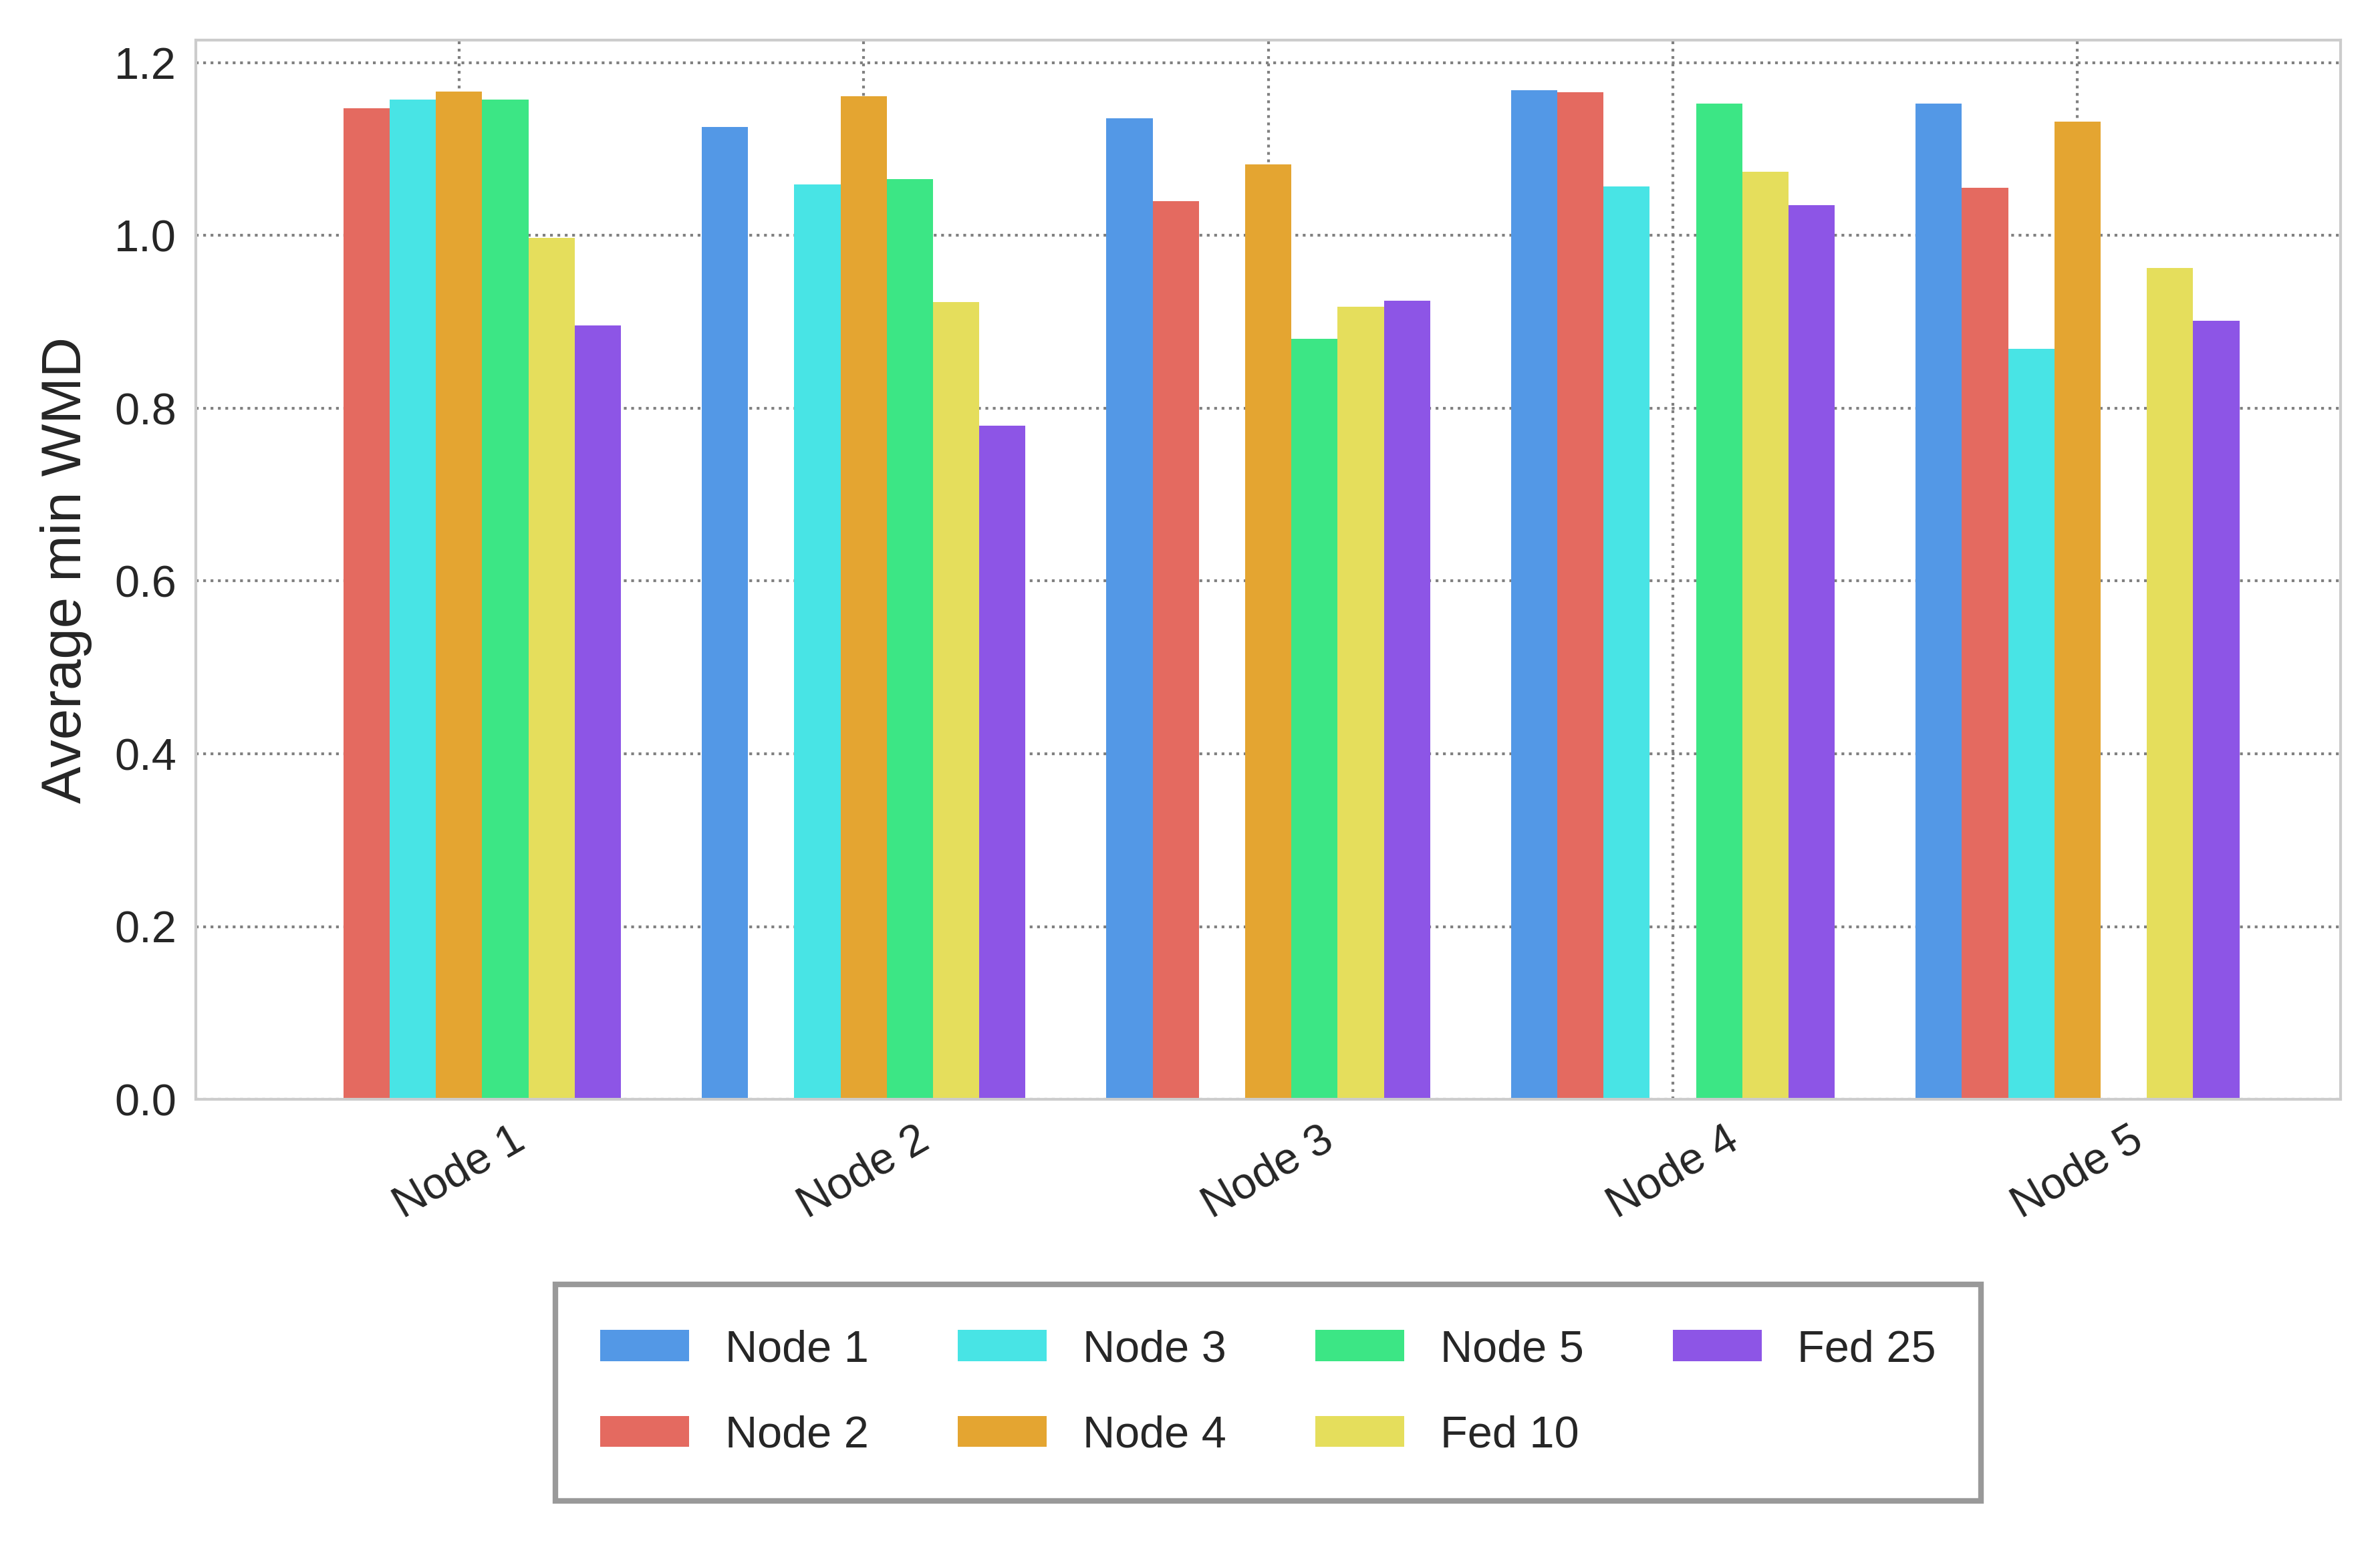

In [34]:
ax = df.plot(kind='bar', rot=30, width=0.8, colormap=cmap)

#ax.legend(bbox_to_anchor=(0.5, -0.63), loc='lower center', ncol=4, fontsize=14)

# Add the legend outside the figure
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, frameon=True, borderpad=1, labelspacing=1)

ax.set_ylabel("Average min WMD")

## 100 words

In [ ]:
n_words = 100
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

# creating a list of index names
index_values = ['Node ' + str(el) for el in range(5)]

# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']

In [ ]:
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
print(df)

# Create plot
ax = df.plot.bar(rot=30,colormap='Accent')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Average min WMDE")

## 200 words

In [ ]:
n_words = 200
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

# creating a list of index names
index_values = ['Node ' + str(el) for el in range(5)]

# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']

          Node 0    Node 1    Node 2    Node 3    Node 4    Fed 10    Fed 25
Node 0  0.000000  1.014605  1.051253  1.063333  1.069004  0.874942  0.707054
Node 1  0.994146  0.000000  0.944999  1.045831  0.947482  0.783506  0.621073
Node 2  1.037059  0.921370  0.000000  0.973444  0.776984  0.812672  0.780132
Node 3  1.054082  1.049182  0.963957  0.000000  1.010196  0.973645  0.878391
Node 4  1.052530  0.939187  0.770568  1.015427  0.000000  0.861120  0.770386


Text(0, 0.5, 'Average mean WMDE')

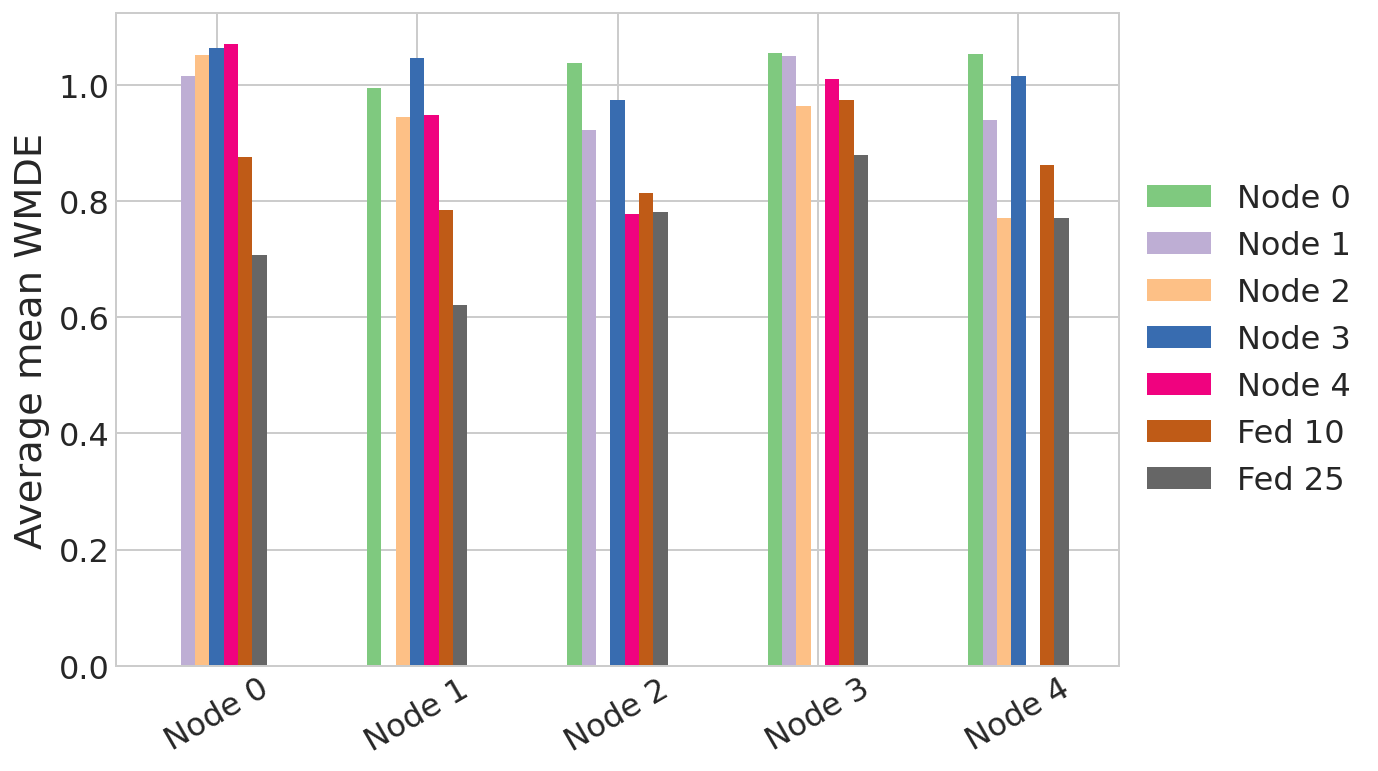

In [86]:
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
print(df)

# Create plot
ax = df.plot.bar(rot=30,colormap='Accent')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Average min WMDE")

## 300 words

In [ ]:
n_words = 300
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

# creating a list of index names
index_values = ['Node ' + str(el) for el in range(5)]

# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']

In [ ]:
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
print(df)

# Create plot
ax = df.plot.bar(rot=30,colormap='Accent')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Average mean WMDE")

## 20 words

In [ ]:
n_words = 20
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

# creating a list of index names
index_values = ['Node ' + str(el) for el in range(5)]

# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 25']

In [ ]:
# creating the dataframe
df = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
print(df)

# Create plot
ax = df.plot.bar(rot=30,colormap='Accent')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Average mean WMDE")